# EfficientDet Training On A Custom Dataset



<table align="left"><td>
  <a target="_blank"  href="https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/blob/master/tutorial/train_shape.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.research.google.com/github/zylo117/Yet-Another-EfficientDet-Pytorch/blob/master/tutorial/train_shape.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

## This tutorial will show you how to train a custom dataset.

## For the sake of simplicity, I generated a dataset of different shapes, like rectangles, triangles, circles.

## Please enable GPU support to accelerate on notebook setting if you are using colab.

### 0. Install Requirements

In [1]:
!pip install numpy==1.21.6 torch==1.12.1 torchvision==0.13.1 opencv-python==4.5.4.60
!pip install pycocotools numpy==1.21.6 opencv-python==4.5.4 tqdm tensorboard tensorboardX pyyaml webcolors matplotlib
!pip install torch==1.12.1 torchvision==0.13.1

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.5.4 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84)
ERROR: No matching distribution found for opencv-python==4.5.4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Prepare Custom Dataset/Pretrained Weights + YOLO to json

In [ ]:
import os
import shutil

def organize_dataset(image_src_dir, label_src_dir, dest_dir):
    """
    이미지와 라벨 파일을 지정된 경로로 복사 및 정리하는 함수.

    Args:
        image_src_dir (str): 원본 이미지 파일이 위치한 디렉토리 경로.
        label_src_dir (str): 원본 라벨 파일이 위치한 디렉토리 경로.
        dest_dir (str): 데이터셋을 정리할 최종 경로.

    """
    # 대상 디렉토리 생성
    image_dest_dir = os.path.join(dest_dir, "images")
    label_dest_dir = os.path.join(dest_dir, "labels")
    os.makedirs(image_dest_dir, exist_ok=True)
    os.makedirs(label_dest_dir, exist_ok=True)

    # 이미지 파일 복사
    for file_name in os.listdir(image_src_dir):
        if file_name.endswith((".jpg", ".png", ".jpeg")):  # 이미지 확장자 확인
            src_path = os.path.join(image_src_dir, file_name)
            dest_path = os.path.join(image_dest_dir, file_name)
            shutil.copy(src_path, dest_path)
            print(f"이미지 복사: {src_path} → {dest_path}")

    # 라벨 파일 복사
    for file_name in os.listdir(label_src_dir):
        if file_name.endswith(".txt"):  # 라벨 파일 확장자 확인
            src_path = os.path.join(label_src_dir, file_name)
            dest_path = os.path.join(label_dest_dir, file_name)
            shutil.copy(src_path, dest_path)
            print(f"라벨 복사: {src_path} → {dest_path}")

    print("\n데이터셋 정리가 완료되었습니다!")
    print(f"이미지 경로: {image_dest_dir}")
    print(f"라벨 경로: {label_dest_dir}")

# 사용 예시
image_src_dir = "/content/drive/MyDrive/datasets/augmented_train/images"  # 이미지가 있는 원본 디렉토리
label_src_dir = "/content/drive/MyDrive/datasets/augmented_train/labels"  # 라벨이 있는 원본 디렉토리
dest_dir = "/content/drive/MyDrive/dataset/train"  # 데이터를 정리할 최종 디렉토리

organize_dataset(image_src_dir, label_src_dir, dest_dir)

In [ ]:
import os
import json
from PIL import Image

def yolo_to_coco(yolo_dir, save_path, class_names):
    """
    YOLO 형식 데이터를 COCO 형식 JSON으로 변환
    Args:
        yolo_dir (str): YOLO 데이터 디렉토리 (images와 labels 디렉토리가 포함된 상위 디렉토리).
        save_path (str): 변환된 COCO JSON 파일을 저장할 경로.
        class_names (list): 클래스 이름 리스트. 예: ['class1', 'class2', ...].
    """
    print("YOLO → COCO 변환 시작...")

    images = []
    annotations = []
    categories = []

    # 클래스 정보 추가
    print("카테고리 추가 중...")
    for idx, class_name in enumerate(class_names):
        categories.append({
            "id": idx + 1,
            "name": class_name
        })
    print(f"카테고리 등록 완료: {categories}")

    annotation_id = 1  # 각 객체의 고유 ID
    label_dir = os.path.join(yolo_dir, "labels")
    image_dir = os.path.join(yolo_dir, "images")

    print("라벨 디렉토리:", label_dir)
    print("이미지 디렉토리:", image_dir)

    # 이미지 및 라벨 파일 읽기
    for label_file in os.listdir(label_dir):
        if not label_file.endswith(".txt"):
            continue

        print(f"처리 중인 라벨 파일: {label_file}")

        # 이미지 파일과 라벨 파일 매칭
        image_id = len(images) + 1
        image_name = label_file.replace(".txt", ".jpg")
        image_path = os.path.join(image_dir, image_name)

        if not os.path.exists(image_path):
            print(f"[경고] 이미지 파일을 찾을 수 없습니다: {image_path}")
            continue

        try:
            with Image.open(image_path) as img:
                width, height = img.size
        except Exception as e:
            print(f"[오류] 이미지 파일을 열 수 없습니다: {image_path}, 오류: {e}")
            continue

        images.append({
            "id": image_id,
            "file_name": image_name,
            "width": width,
            "height": height
        })

        print(f"이미지 추가 완료: {image_name} (ID: {image_id})")

        # 라벨 파일 읽기
        with open(os.path.join(label_dir, label_file), "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                box_width = float(parts[3])
                box_height = float(parts[4])

                x_min = (x_center - box_width / 2) * width
                y_min = (y_center - box_height / 2) * height
                bbox_width = box_width * width
                bbox_height = box_height * height

                annotations.append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": class_id + 1,
                    "bbox": [x_min, y_min, bbox_width, bbox_height],
                    "area": bbox_width * bbox_height,
                    "iscrowd": 0
                })
                print(f"   -> 바운딩 박스 추가: {annotations[-1]}")
                annotation_id += 1

    # COCO JSON 구조
    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    # JSON 파일 저장 전에 디렉토리 생성
    save_dir = os.path.dirname(save_path)
    os.makedirs(save_dir, exist_ok=True)  # 디렉토리가 없으면 생성

    # JSON 파일 저장
    try:
        with open(save_path, "w") as json_file:
            json.dump(coco_format, json_file, indent=4)
        print(f"COCO JSON 파일이 {save_path}에 저장되었습니다.")
    except Exception as e:
        print(f"[오류] JSON 파일 저장 실패: {e}")

# 사용 예시
yolo_dir = "/content/drive/MyDrive/EfficientDet/dataset/val"  # YOLO 데이터 디렉토리 경로
save_path = "/content/drive/MyDrive/annotations/val_annotations.json"  # 저장할 JSON 경로
class_names = ["nameplate_working", "insignia_working", "rankbadge_working"]  # 클래스 이름 리스트

# 실행
yolo_to_coco(yolo_dir, save_path, class_names)

In [ ]:
import os
import shutil

def copy_files(src_dir, dest_dir, file_extensions=None):
    """
    특정 디렉토리의 파일을 다른 디렉토리로 복사
    Args:
        src_dir (str): 원본 디렉토리 경로
        dest_dir (str): 복사할 대상 디렉토리 경로
        file_extensions (list, optional): 복사할 파일 확장자 리스트. None이면 모든 파일 복사.
    """
    # 대상 디렉토리 생성
    os.makedirs(dest_dir, exist_ok=True)

    # 원본 디렉토리의 파일 복사
    for file_name in os.listdir(src_dir):
        # 파일 확장자 필터링
        if file_extensions:
            if not file_name.lower().endswith(tuple(file_extensions)):
                continue

        # 파일 복사
        src_file = os.path.join(src_dir, file_name)
        dest_file = os.path.join(dest_dir, file_name)

        if os.path.isfile(src_file):  # 파일만 복사
            shutil.copy(src_file, dest_file)
            print(f"복사 완료: {src_file} → {dest_file}")

# 사용 예제
src_directory = "/content/drive/MyDrive/EfficientDet/dataset/val/images"  # 복사할 원본 디렉토리 경로
dest_directory = "/content/drive/MyDrive/datasets/shape/images/val"  # 복사할 대상 디렉토리 경로
file_exts = [".jpg", ".png", ".txt"]  # 복사할 파일 확장자 (예: 이미지와 텍스트 파일)

copy_files(src_directory, dest_directory, file_exts)

In [3]:
import os
import sys

# 1. 프로젝트 클론 및 설정
if "projects" not in os.getcwd():
    !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
    os.chdir('Yet-Another-EfficientDet-Pytorch')
    sys.path.append('.')
else:
    !git pull

# 2. 데이터셋 디렉토리 설정 (사용자 데이터셋 사용)
# Google Drive 경로에 데이터셋 디렉토리를 생성
dataset_dir = "/content/drive/MyDrive/datasets/shape"
os.makedirs(os.path.join(dataset_dir, "images/train"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "images/val"), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, "annotations"), exist_ok=True)

# 3. 가중치 디렉토리 생성 및 다운로드
weights_dir = "weights"
os.makedirs(weights_dir, exist_ok=True)
if not os.path.exists(os.path.join(weights_dir, "efficientdet-d0.pth")):
    !wget https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d0.pth -O weights/efficientdet-d0.pth

# 4. 데이터셋 디렉토리 및 가중치 파일 확인
print("데이터셋 디렉토리 구조 확인:")
!ls -R /content/drive/MyDrive/datasets/shape
print("\n가중치 파일 확인:")
!ls weights

Cloning into 'Yet-Another-EfficientDet-Pytorch'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 3), reused 24 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 5.66 MiB | 28.86 MiB/s, done.
Resolving deltas: 100% (3/3), done.
--2024-12-23 16:53:46--  https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d0.pth
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/253385242/9b9d2100-791d-11ea-80b2-d35899cf95fe?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Credential=releaseassetproduction%2F20241223%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20241223T165346Z&X-Amz-Expires=300&X-Amz-Signature=2875481985a0a73a731094bf92e222b3f30

In [4]:
!mkdir -p datasets/shape/annotations
!cp /content/drive/MyDrive/datasets/shape/annotations/instances_train.json datasets/shape/annotations/instances_train.json
!cp /content/drive/MyDrive/datasets/shape/annotations/instances_val.json datasets/shape/annotations/instances_val.json
!ls datasets/shape/annotations/

instances_train.json  instances_val.json


### 2. Training

In [16]:
%%writefile /content/Yet-Another-EfficientDet-Pytorch/projects/shape.yml
project_name: shape
train_set: train
val_set: val
num_gpus: 1

mean: [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]

obj_list: ['nameplate_working', 'insignia_working', 'rankbadge_working']

anchors_ratios: "[1, 2, 0.5]"
anchors_scales: "[1, 1.2599, 1.5874]"

Overwriting /content/Yet-Another-EfficientDet-Pytorch/projects/shape.yml


In [6]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.4 MB/s eta 0:00:00


In [7]:
%%writefile /content/Yet-Another-EfficientDet-Pytorch/train.py

# original author: signatrix
# adapted from https://github.com/signatrix/efficientdet/blob/master/train.py
# modified by Zylo117

import argparse
import datetime
import os
import traceback

import numpy as np
import torch
import yaml
from tensorboardX import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm

from backbone import EfficientDetBackbone
from efficientdet.dataset import CocoDataset, Resizer, Normalizer, Augmenter, collater
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string


class Params:
    def __init__(self, project_file):
        self.params = yaml.safe_load(open(project_file).read())

    def __getattr__(self, item):
        return self.params.get(item, None)


def get_args():
    parser = argparse.ArgumentParser('Yet Another EfficientDet Pytorch: SOTA object detection network - Zylo117')
    parser.add_argument('-p', '--project', type=str, default='coco', help='project file that contains parameters')
    parser.add_argument('-c', '--compound_coef', type=int, default=0, help='coefficients of efficientdet')
    parser.add_argument('-n', '--num_workers', type=int, default=12, help='num_workers of dataloader')
    parser.add_argument('--batch_size', type=int, default=12, help='The number of images per batch among all devices')
    parser.add_argument('--head_only', type=boolean_string, default=False,
                        help='whether finetunes only the regressor and the classifier, '
                             'useful in early stage convergence or small/easy dataset')
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--optim', type=str, default='adamw', help='select optimizer for training, '
                                                                   'suggest using \'admaw\' until the'
                                                                   ' very final stage then switch to \'sgd\'')
    parser.add_argument('--num_epochs', type=int, default=500)
    parser.add_argument('--val_interval', type=int, default=1, help='Number of epoches between valing phases')
    parser.add_argument('--save_interval', type=int, default=500, help='Number of steps between saving')
    parser.add_argument('--es_min_delta', type=float, default=0.0,
                        help='Early stopping\'s parameter: minimum change loss to qualify as an improvement')
    parser.add_argument('--es_patience', type=int, default=0,
                        help='Early stopping\'s parameter: number of epochs with no improvement after which training will be stopped. Set to 0 to disable this technique.')
    parser.add_argument('--data_path', type=str, default='datasets/', help='the root folder of dataset')
    parser.add_argument('--log_path', type=str, default='logs/')
    parser.add_argument('-w', '--load_weights', type=str, default=None,
                        help='whether to load weights from a checkpoint, set None to initialize, set \'last\' to load last checkpoint')
    parser.add_argument('--saved_path', type=str, default='logs/')
    parser.add_argument('--debug', type=boolean_string, default=False,
                        help='whether visualize the predicted boxes of training, '
                             'the output images will be in test/')

    args = parser.parse_args()
    return args


class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss


def train(opt):
    params = Params(f'projects/{opt.project}.yml')

    if params.num_gpus == 0:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    else:
        torch.manual_seed(42)

    opt.saved_path = opt.saved_path + f'/{params.project_name}/'
    opt.log_path = opt.log_path + f'/{params.project_name}/tensorboard/'
    os.makedirs(opt.log_path, exist_ok=True)
    os.makedirs(opt.saved_path, exist_ok=True)

    training_params = {'batch_size': opt.batch_size,
                       'shuffle': True,
                       'drop_last': True,
                       'collate_fn': collater,
                       'num_workers': opt.num_workers}

    val_params = {'batch_size': opt.batch_size,
                  'shuffle': False,
                  'drop_last': True,
                  'collate_fn': collater,
                  'num_workers': opt.num_workers}

    input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]
    training_set = CocoDataset(root_dir=os.path.join(opt.data_path, params.project_name), set=params.train_set,
                               transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                             Augmenter(),
                                                             Resizer(input_sizes[opt.compound_coef])]))
    training_generator = DataLoader(training_set, **training_params)

    val_set = CocoDataset(root_dir=os.path.join(opt.data_path, params.project_name), set=params.val_set,
                          transform=transforms.Compose([Normalizer(mean=params.mean, std=params.std),
                                                        Resizer(input_sizes[opt.compound_coef])]))
    val_generator = DataLoader(val_set, **val_params)

    print("Anchors Ratios (raw):", params.anchors_ratios)  # Anchors Ratios 확인
    print("Anchors Scales (raw):", params.anchors_scales)  # Anchors Scales 확인

    model = EfficientDetBackbone(num_classes=len(params.obj_list), compound_coef=opt.compound_coef,
                                 ratios=eval(params.anchors_ratios), scales=eval(params.anchors_scales))

    # load last weights
    if opt.load_weights is not None:
        if opt.load_weights.endswith('.pth'):
            weights_path = opt.load_weights
        else:
            weights_path = get_last_weights(opt.saved_path)
        try:
            last_step = int(os.path.basename(weights_path).split('_')[-1].split('.')[0])
        except:
            last_step = 0

        try:
            ret = model.load_state_dict(torch.load(weights_path), strict=False)
        except RuntimeError as e:
            print(f'[Warning] Ignoring {e}')
            print(
                '[Warning] Don\'t panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.')

        print(f'[Info] loaded weights: {os.path.basename(weights_path)}, resuming checkpoint from step: {last_step}')
    else:
        last_step = 0
        print('[Info] initializing weights...')
        init_weights(model)

    # freeze backbone if train head_only
    if opt.head_only:
        def freeze_backbone(m):
            classname = m.__class__.__name__
            for ntl in ['EfficientNet', 'BiFPN']:
                if ntl in classname:
                    for param in m.parameters():
                        param.requires_grad = False

        model.apply(freeze_backbone)
        print('[Info] freezed backbone')

    # https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
    # apply sync_bn when using multiple gpu and batch_size per gpu is lower than 4
    #  useful when gpu memory is limited.
    # because when bn is disable, the training will be very unstable or slow to converge,
    # apply sync_bn can solve it,
    # by packing all mini-batch across all gpus as one batch and normalize, then send it back to all gpus.
    # but it would also slow down the training by a little bit.
    if params.num_gpus > 1 and opt.batch_size // params.num_gpus < 4:
        model.apply(replace_w_sync_bn)
        use_sync_bn = True
    else:
        use_sync_bn = False

    writer = SummaryWriter(opt.log_path + f'/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/')

    # warp the model with loss function, to reduce the memory usage on gpu0 and speedup
    model = ModelWithLoss(model, debug=opt.debug)

    if params.num_gpus > 0:
        model = model.cuda()
        if params.num_gpus > 1:
            model = CustomDataParallel(model, params.num_gpus)
            if use_sync_bn:
                patch_replication_callback(model)

    if opt.optim == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), opt.lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), opt.lr, momentum=0.9, nesterov=True)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    epoch = 0
    best_loss = 1e5
    best_epoch = 0
    step = max(0, last_step)
    model.train()

    num_iter_per_epoch = len(training_generator)

    try:
        for epoch in range(opt.num_epochs):
            last_epoch = step // num_iter_per_epoch
            if epoch < last_epoch:
                continue

            epoch_loss = []
            progress_bar = tqdm(training_generator)
            for iter, data in enumerate(progress_bar):
                if iter < step - last_epoch * num_iter_per_epoch:
                    progress_bar.update()
                    continue
                try:
                    imgs = data['img']
                    annot = data['annot']

                    if params.num_gpus == 1:
                        # if only one gpu, just send it to cuda:0
                        # elif multiple gpus, send it to multiple gpus in CustomDataParallel, not here
                        imgs = imgs.cuda()
                        annot = annot.cuda()

                    optimizer.zero_grad()
                    cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
                    cls_loss = cls_loss.mean()
                    reg_loss = reg_loss.mean()

                    loss = cls_loss + reg_loss
                    if loss == 0 or not torch.isfinite(loss):
                        continue

                    loss.backward()
                    # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                    optimizer.step()

                    epoch_loss.append(float(loss))

                    progress_bar.set_description(
                        'Step: {}. Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Total loss: {:.5f}'.format(
                            step, epoch, opt.num_epochs, iter + 1, num_iter_per_epoch, cls_loss.item(),
                            reg_loss.item(), loss.item()))
                    writer.add_scalars('Loss', {'train': loss}, step)
                    writer.add_scalars('Regression_loss', {'train': reg_loss}, step)
                    writer.add_scalars('Classfication_loss', {'train': cls_loss}, step)

                    # log learning_rate
                    current_lr = optimizer.param_groups[0]['lr']
                    writer.add_scalar('learning_rate', current_lr, step)

                    step += 1

                    if step % opt.save_interval == 0 and step > 0:
                        save_checkpoint(model, f'efficientdet-d{opt.compound_coef}_{epoch}_{step}.pth')
                        print('checkpoint...')

                except Exception as e:
                    print('[Error]', traceback.format_exc())
                    print(e)
                    continue
            scheduler.step(np.mean(epoch_loss))

            if epoch % opt.val_interval == 0:
                model.eval()
                loss_regression_ls = []
                loss_classification_ls = []
                for iter, data in enumerate(val_generator):
                    with torch.no_grad():
                        imgs = data['img']
                        annot = data['annot']

                        if params.num_gpus == 1:
                            imgs = imgs.cuda()
                            annot = annot.cuda()

                        cls_loss, reg_loss = model(imgs, annot, obj_list=params.obj_list)
                        cls_loss = cls_loss.mean()
                        reg_loss = reg_loss.mean()

                        loss = cls_loss + reg_loss
                        if loss == 0 or not torch.isfinite(loss):
                            continue

                        loss_classification_ls.append(cls_loss.item())
                        loss_regression_ls.append(reg_loss.item())

                cls_loss = np.mean(loss_classification_ls)
                reg_loss = np.mean(loss_regression_ls)
                loss = cls_loss + reg_loss

                print(
                    'Val. Epoch: {}/{}. Classification loss: {:1.5f}. Regression loss: {:1.5f}. Total loss: {:1.5f}'.format(
                        epoch, opt.num_epochs, cls_loss, reg_loss, loss))
                writer.add_scalars('Loss', {'val': loss}, step)
                writer.add_scalars('Regression_loss', {'val': reg_loss}, step)
                writer.add_scalars('Classfication_loss', {'val': cls_loss}, step)

                if loss + opt.es_min_delta < best_loss:
                    best_loss = loss
                    best_epoch = epoch

                    save_checkpoint(model, f'efficientdet-d{opt.compound_coef}_{epoch}_{step}.pth')

                model.train()

                # Early stopping
                if epoch - best_epoch > opt.es_patience > 0:
                    print('[Info] Stop training at epoch {}. The lowest loss achieved is {}'.format(epoch, best_loss))
                    break
    except KeyboardInterrupt:
        save_checkpoint(model, f'efficientdet-d{opt.compound_coef}_{epoch}_{step}.pth')
        writer.close()
    writer.close()


def save_checkpoint(model, name):
    if isinstance(model, CustomDataParallel):
        torch.save(model.module.model.state_dict(), os.path.join(opt.saved_path, name))
    else:
        torch.save(model.model.state_dict(), os.path.join(opt.saved_path, name))


if __name__ == '__main__':
    opt = get_args()
    train(opt)

Overwriting /content/Yet-Another-EfficientDet-Pytorch/train.py


In [26]:
!cat /content/Yet-Another-EfficientDet-Pytorch/projects/shape.yml

project_name: shape
train_set: train
val_set: val
num_gpus: 1

mean: [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]

obj_list: ['nameplate_working', 'insignia_working', 'rankbadge_working']

anchors_ratios: "[1, 2, 0.5]"
anchors_scales: "[1, 1.2599, 1.5874]"


In [27]:
# consider this is a simple dataset, train head will be enough.
! python train.py -c 0 -p shape --head_only True --lr 1e-3 --batch_size 32 --load_weights weights/efficientdet-d0.pth  --num_epochs 50 --save_interval 100

# the loss will be high at first
# don't panic, be patient,
# just wait for a little bit longer

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Anchors Ratios (raw): [1, 2, 0.5]
Anchors Scales (raw): [1, 1.2599, 1.5874]
[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([27, 64, 1, 1]).
	size misma

In [29]:
import os
import json

# JSON 파일 경로
json_path = "/datasets/shape/annotations/instances_train.json"

# 이미지 디렉토리
image_dir = "/datasets/shape/images/train"

# JSON 데이터 로드
with open(json_path, "r") as file:
    data = json.load(file)

json_images = [img["file_name"] for img in data["images"]]
print(f"JSON에 기록된 이미지 수: {len(json_images)}")

# 실제 디렉토리의 이미지
actual_images = os.listdir(image_dir)
print(f"실제 디렉토리 이미지 수: {len(actual_images)}")

# 불일치 확인
missing_images = [img for img in json_images if img not in actual_images]
if missing_images:
    print("[Error] JSON에 기록되었지만 실제로 없는 이미지들:", missing_images)
else:
    print("[Info] JSON과 실제 이미지가 일치합니다.")

NameError: name 'data' is not defined

### 3. Evaluation

In [ ]:
#get latest weight file
%cd logs/shape
weight_file = !ls -Art | grep efficientdet
%cd ../..

#uncomment the next line to specify a weight file
#weight_file[-1] = 'efficientdet-d0_49_1400.pth'

! python coco_eval.py -c 0 -p shape -w "logs/shape/{weight_file[-1]}"

running coco-style evaluation on project shape, weights logs/shape/efficientdet-d0_49_1400.pth...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
100% 100/100 [00:08<00:00, 11.80it/s]
Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.46s).
Accumulating evaluation results...
DONE (t=0.14s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.868
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.470
 Av

### 4. Visualize

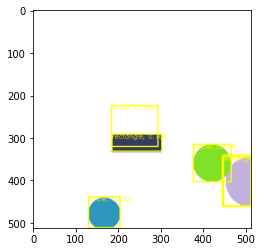

In [ ]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 0
force_input_size = None  # set None to use default size
img_path = 'datasets/shape/val/999.jpg'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ['rectangle', 'circle']

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/shape/'+weight_file[-1]))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])

